# Really simple (Vectorized, Double) DQN. With Proritized Experience Replay, and Distributional DQN.


>  ...Read about what’s called DQN... Policy gradients, particular A3C... Just go to /r/machinelearning on Reddit and look at some recent papers in the deep neural net literature. Look at them try to re-implement [them], see if you can get results as good as the results that others get. It’s really pretty self-contained and you don’t need that much help... If you’re having trouble getting started implementing them... you can find it an existing implementation then start with that and try to fiddle with it to see if you can make it better...

> [Dario Amodi, on 80,000 hours podcast](https://80000hours.org/podcast/episodes/the-world-needs-ai-researchers-heres-how-to-become-one/)

During May and June 2018 I've been reading reinforcement learning papers, watching lectures and more or less trying to follow the path Dario Amodi lays out, driven by similar motivations: I'm an active, enthusiastic Effective Altruist, and I buy the AI Safety arguments. Even if you don't see General AI as a threat, there are still clearly safety and alignment issues to think about with current and future ML/AI systems. And it's a good/interesting/exciting career path. 

In this document I present my implementations and discuss some relevant issues and questions. I think my DQN implementation in particular might be more straightforward and readable than other implementations I've seen. 

I am a neophyte in this field. This is a document of my exploration and learning process. I am not an authoritative source.

I have be using OpenAI's gym as our training environments, and have trialed both Keras and Pytorch for different parts of this work. I've been almost entirely working alone on this, but have found some excellent explainitory material. In particular, Jaomiru's [Let’s make a DQN](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/) series was helpful getting started, but I've also re-learned the lesson I constantly learn and relearn: sometimes you need to seek out additional material to understand things. But sometimes you're just scared to sit with a difficult thing and wrestle with it. Sometimes it's difficult to know when you're unproductively banging your head against a wall, and when you're productively banging your head against a wall. 

All right then. Let's begin.

In [104]:
from collections import deque
import math
import random
import warnings

import attr
import keras
import gym
from matplotlib import pyplot as plt
import numpy as np
from smooth import smooth

# Keras triggers an warning we don't care about:
warnings.filterwarnings('ignore')

Almost all my explorations have been in the simpler Gym environments to increase speed of development and avoid unnecessary complexity. The original DeepMind papers on learning to play Atari used convo nets and raw pixels, but the preprocessing for the pixels iteself adds extra complexity and we can implement DQN using a much simpler ReLU agent.

In [78]:
@attr.s
class Memory(deque):
    size = attr.ib()
    minibatch_size = attr.ib()

    def append(self, thing):
        if len(self) > self.size - 1:
            self.popleft()
        return super().append(thing)

    def sample(self):
        batch_size = min(len(self), self.minibatch_size)
        return random.sample(self, batch_size)

    
def make_network(state_shape, action_shape, num_hidden_units):
    net = keras.Sequential()
    net.add(keras.layers.Dense(num_hidden_units, activation='relu', input_shape=state_shape))
    net.add(keras.layers.Dense(action_shape, activation='linear'))    
    net.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')
    return net

> Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as Q) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to Q may significantly change the policy and therefore change the data distribution, and the correlations between the action-values (Q) and the target values $r + \gamma\max_a Q(s', a')$. We address these instabilities with a novel variant of Q-learning, which uses two key ideas. 

> **First, we used a biologically inspired mechanism termed experience replay that randomizes over the data, thereby removing correlations in the observation sequence and smoothing over changes in the data distribution...**

> **Second, we used an iterative update that adjusts the action-values (Q) towards target values that are only periodically updated, thereby reducing correlations with the target.**

> [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

The replay memory stores transitions the agent sees while interacting with the environment. We will sample from the replay memory during training -- this increases the data efficiency of training and was one of the 

In [146]:
@attr.s
class DqnBaseClass:
    env = attr.ib()
    discount_rate = attr.ib(default=0.99)
    epsilon_max = attr.ib(default=1.0)
    epsilon_min = attr.ib(default=0.01)
    annealing_const = attr.ib(default=.001)  # aka Lambda
    minibatch_size = attr.ib(default=64)
    memory_size = attr.ib(default=1e6)
    num_episodes = attr.ib(default=1000)  # num of episodes in a training epoch
    num_hidden_units = attr.ib(default=64)
    render_every = attr.ib(default=20)  # set to zero to turn off rendering
    update_target_every = attr.ib(default=200)

    def __attrs_post_init__(self):
        self.steps = 0
        self.reset_memory()
        self.reset_data_recorders()
        self.state_shape = self.env.observation_space.shape
        self.action_shape = self.env.action_space.n
        self.online_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units)

    def reset_memory(self):
        self.memory = Memory(self.memory_size, self.minibatch_size)

    def reset_data_recorders(self):
        self.episode_rewards = []
        self.episode_losses = []
        self.td_errors = []
        self.online_net_q_values = []
        self.target_net_q_values = []
        self.w1_gradient = []
        self.w2_gradient = []

    def q_value_one(self, net, state):
        return net.predict(state.reshape((1, self.state_shape[0]))).flatten()

    def training_rewards_string(self, episode):
        last_ep = self.episode_rewards[-1]
        ten_ep_mean = sum(self.episode_rewards[-10:])/len(self.episode_rewards[-10:])
        hundred_ep_mean = sum(self.episode_rewards[-100:])/len(self.episode_rewards[-100:])
        return f'Ep: {episode} // steps: {self.steps} // last ep reward: {last_ep:.2f} // {min(10, len(self.episode_rewards[-10:]))}-ep mean: {ten_ep_mean:.2f} // {min(100, len(self.episode_rewards[-100:]))}-ep mean: {hundred_ep_mean:.2f}'

    def render(self, episode):
        if self.render_every and episode % self.render_every == 0:
            self.env.render()

    def run(self):
        raise NotImplementedError

Because we're going to be developing DQN agents incrementally I believe it's justifiable to have a base class that captures commonalities, and encapsulates training data. Having done a lot of development in Jupyer notebooks, I've learned to be quite careful about not cluttering the global scope with unnecessary objects or data. 

Our first iteration we're just going to implement the replay buffer and skip the target network. This is the algorithm we're working towards implementing:

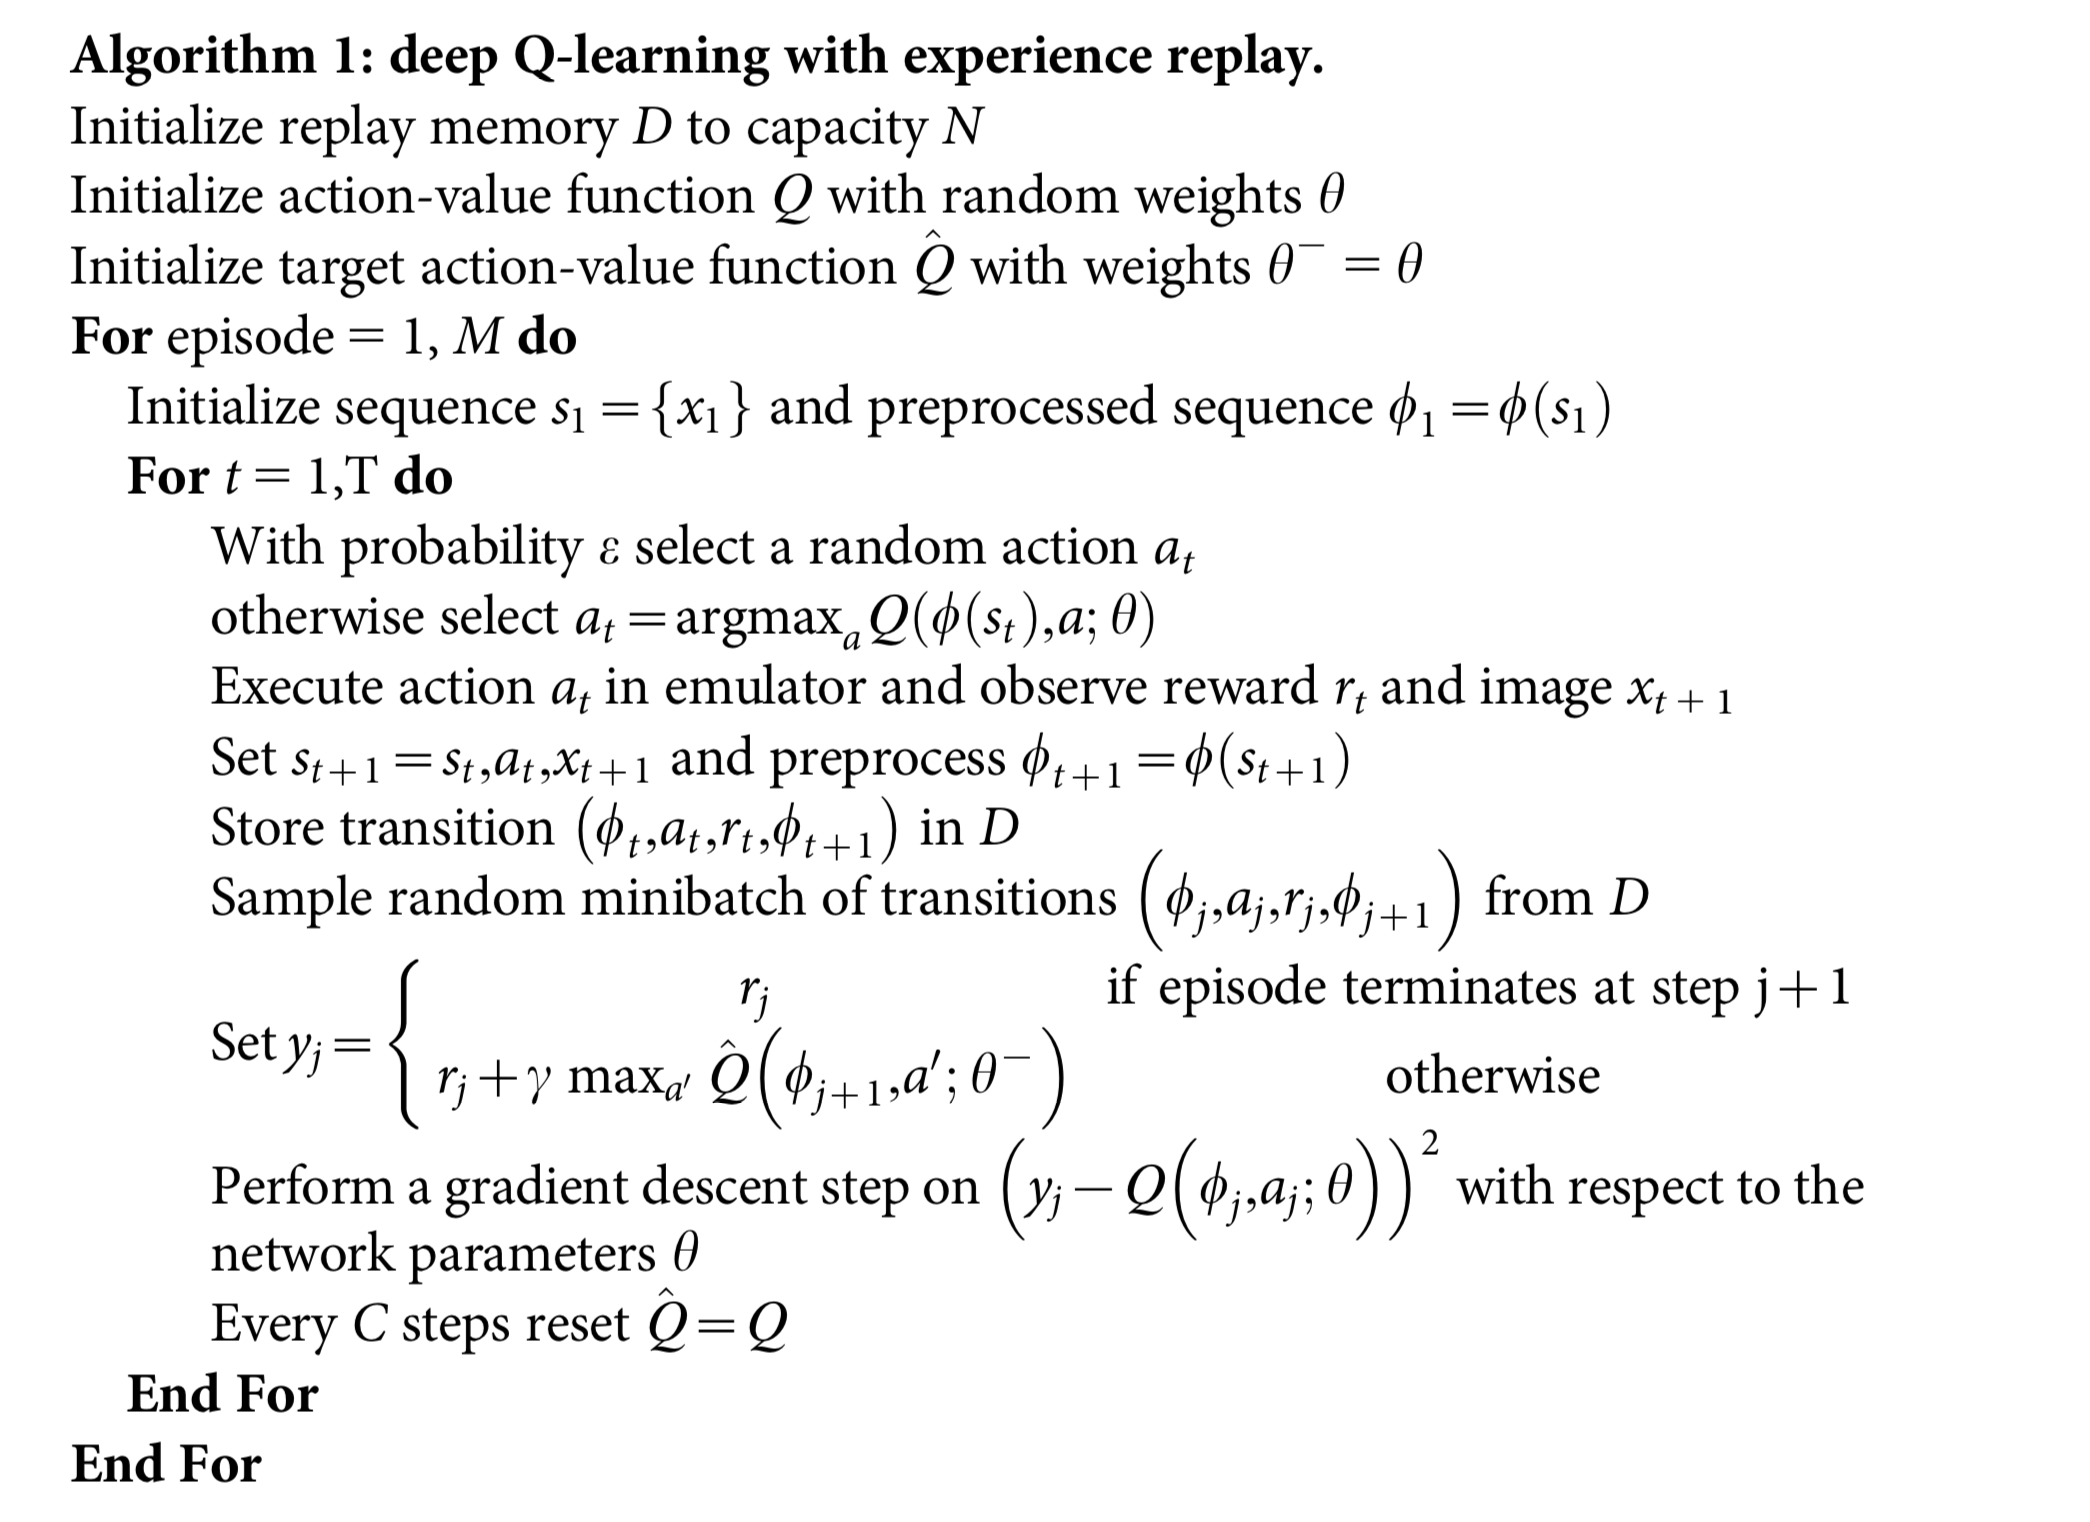

We're going to ignore the parts that deal with $\phi$ and preprocessing -- those are details that are specific to working with images as input. Personally, I found those parts of the algorithm specification confusing and distracting when I was initially reading the paper. 

Our transitions will be $(state_t, action_t, reward_t, state_{t+1}, done)$, with $done$ indicating that a transition is terminal. We are also not implementing the target network in this initial version -- it will be simple to add in shortly, though.

In [74]:
@attr.s
class VerySimpleDqn(DqnBaseClass):
    """ So simple it's broken. """
    def replay(self, target_net, online_net):
        """ Calculate the target values for y_j on a minibatch and do a gradient descent step. """
        # Q_network gives us Vals for all actions in one forward pass:
        batch = self.memory.sample()  # (minibatch_size x state_shape)
        states = np.array([transition[0] for transition in batch])
        y = target_net.predict(states)  # (minibatch_size, action_shape). These are target scores for state
        terminal_state = np.zeros(self.state_shape)  # We need special handling if the transition is the last in a rollout.
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in batch])
        y_ = target_net.predict(states_)  # (minibatch_size, action_shape). These are target scores for state'

        for idx, transition in enumerate(batch):
            state, action, reward, state_, terminal = transition
            if state_ is None:
                y[idx, action] = reward
            else:
                y[idx, action] = reward + self.discount_rate * np.amax(y_[idx])
        # Q is a func from (state, action) to expected values for each action.
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)

    def run(self):
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            state = self.env.reset()
            self.online_net_q_values.append(self.q_value_one(self.online_net, state).max())
            while not episode_done:
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1
                # Epsilon greedy action:
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.q_value_one(self.online_net, state).argmax()
                    
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                episode_reward += reward
                if episode_done:
                    state_ = None                
                self.memory.append((state, action, reward, state_, episode_done))
                self.replay(target_net=self.online_net, online_net=self.online_net)
                state = state_
                if episode_done:
                    self.episode_rewards.append(episode_reward)
                    print(self.training_rewards_string(episode), end='\r', flush=True)
        self.env.close()

In [75]:
cartpole = gym.make('CartPole-v1')                    
first_dqn = VerySimpleDqn(env=cartpole, num_episodes=300)
first_dqn.run()

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(12, 4))
ax1, ax2 = axes
ax1.plot(first_dqn.episode_rewards)
ax1.set_title('Episode rewards')
ax2.plot(first_dqn.online_net_q_values)
ax2.set_title('Estimated Q values')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


TypeError: render() missing 1 required positional argument: 'episode'

## One weird trick...

Performance is not good. As the original paper says, Q learning with function approx is unstable, and here we can see the Estimated Q values exploding. One of the causes is "the correlations between the action-values (Q) and the target values" which are used to estimate what the values of $state'$ will be. Adding in the target network will address this problem:

In [94]:
@attr.s
class SimpleDqn(VerySimpleDqn):
    def __attrs_post_init__(self):
        super().__attrs_post_init__()
        self.target_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units)
        
        
    def run(self):
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            state = self.env.reset()
            self.online_net_q_values.append(self.q_value_one(self.online_net, state).max())
            self.target_net_q_values.append(self.q_value_one(self.target_net, state).max())
            while not episode_done:
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.q_value_one(self.online_net, state).argmax()
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                episode_reward += reward
                if episode_done:
                    state_ = None                
                self.memory.append((state, action, reward, state_, episode_done))
                self.replay(target_net=self.target_net, online_net=self.online_net)
                state = state_
                if self.steps % self.update_target_every == 0:
                    self.target_net.set_weights(self.online_net.get_weights())
                if episode_done:
                    self.episode_rewards.append(episode_reward)
                    print(self.training_rewards_string(episode), end='\r', flush=True)
        self.env.close()

In [131]:
@attr.s
class DoubleDqn(SimpleDqn):
    def 

In [135]:
dd = DoubleDqn(cartpole)
dd.online_net

Note that the *only* significant difference between `SimpleDqn` and `VerySimpleDqn`, its parent, is line 28: 

```python
self.replay(target_net=self.target_net, online_net=self.online_net)
```

In `VerySimpleDqn` we only have the `online_net`, so the `online_net` is used both for the state-value estimates and is the objective function that is being optimized. In `SimpleDqn` as per the DeepMind paper, we split those two functions and the result is a massive improvement in the agent. Infact, `VerySimpleDqn` essentially performes about as well as a random agent, whereas `SimpleDqn` quickly learns to saturates the task. However, `SimpleDqn` only really begins to improve after the first update of the target network. Prior to that, it also performs about as well as a random agent. After the first update, there is an almost immediate take-off in learning. 

The authors expand on the reson this improves learning by saying:

> Q-learning, where an update that increases $Q(s_t,a_t)$ often also increases $Q(s_{t+1}, a)$ for all $a$ and hence also increases the target $y_j$, possibly leading to oscillations or divergence of the policy. Generating the targets using an older set of parameters adds a delay between the time an update to $Q$ is made and the time the update affects the targets $y_j$, making divergence or oscillations much more unlikely.

# TODO: run this longer, show learning instability.

In [ ]:
cartpole = gym.make('CartPole-v1')                    
simple_dqn = SimpleDqn(env=cartpole, num_episodes=3000)
simple_dqn.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


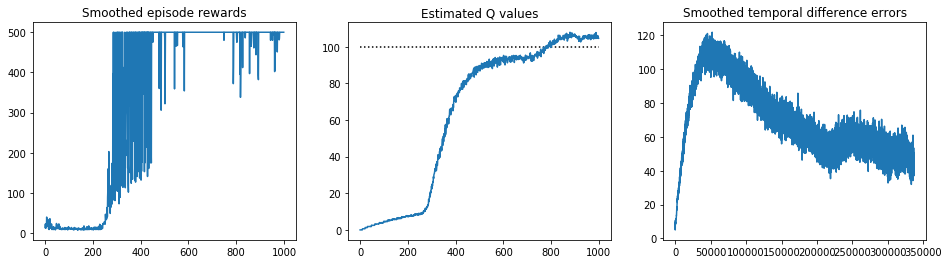

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax1, ax2, ax3 = axes

ax1.plot(smooth(np.array(simple_dqn.episode_rewards)))
ax1.set_title('Smoothed episode rewards')

ax2.plot(simple_dqn.target_net_q_values)
ax2.set_title('Estimated Q values')
ax2.hlines(100, 0, len(simple_dqn.target_net_q_values), linestyles='dotted')

ax3.plot(smooth(np.array(simple_dqn.td_errors), window_len=100))
ax3.set_title('Smoothed temporal difference errors');


# Bells & whistles

There have been a number of extensions and improvements made to the DQN framework. [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf) (2015) is interesting because it's particularly straightforward to implement, and fundamentally very simple to understand -- although the 2015 DeepMind paper almost seems to go out of its way to obscure the issue. 

In DQN the target values are defined as:

$$ y_j = r_j + \gamma \max_{a'} \hat{Q}(s_{j+1}, a') $$ 

Where $\hat{Q}$ stands for the target network, as opposed to $Q$, the online network.

With Double Q-learning we use:

$$ y_j = r_j + \gamma \max_{a'} \hat{Q}(s_{j+1}, \underset{a}{\operatorname{argmax}} Q(s_{j+1}, a))$$ 

The explaination for why this works is quite straightforward, but the 2015 paper doesn't really spell it out. 

- DQN has a severe optimism bias which can very negatively affect learning -- eg, imagine if you're overly optimistic about the 1st choice you make. Exploration stops.
- Double DQN reduces the lower-bound on the absolute error of the Q-value estimates. 

As Hado van Hasselt writes in his PhD disseratation,

> If actions that are selected often suffer from overestimations, these actions will only get selected more and more. On the other hand, if actions that are selected suffer from underestimations, this will give an incentive to the algorithm to try other actions.

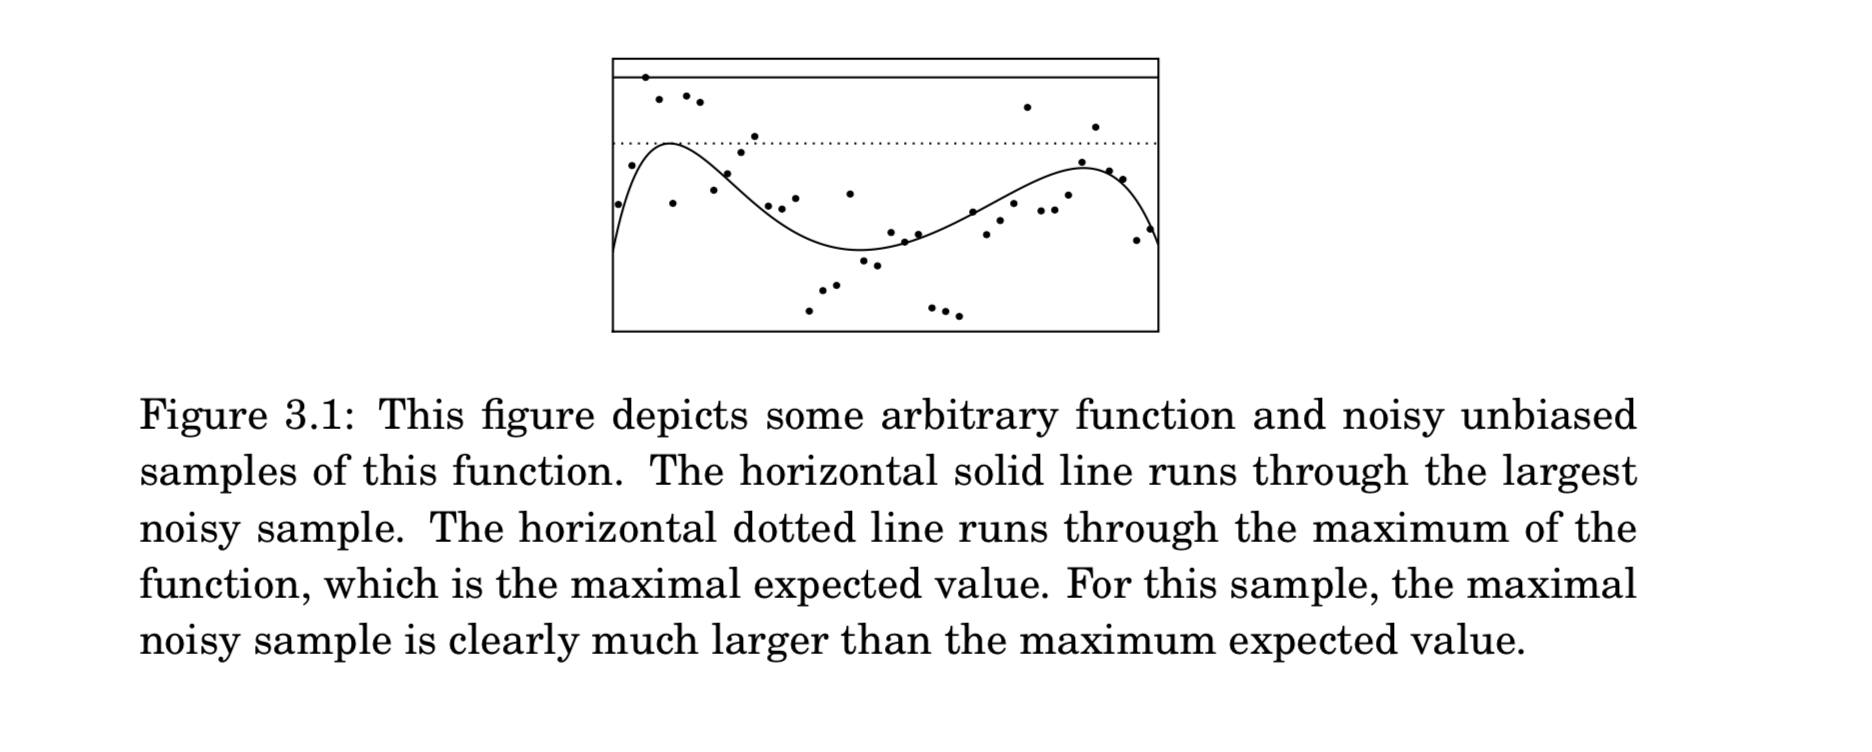

In [139]:
@attr.s
class DoubleDqn(SimpleDqn):
    def replay(self, target_net, online_net):
        # unpack the batch data and convert to nunpy arrays:
        batch = self.memory.sample()  # (minibatch_size x state_shape)
        states = np.array([transition[0] for transition in batch])
        transition_actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])  # (batch x 1)
        terminal_mask = np.array([True if transition[3] is None else False for transition in batch])  # (batch x 1)
        terminal_state = np.zeros(self.state_shape)
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in batch])  # (batch x state-size)

        y = target_net.predict(states)  # (batch x num-actions)
        online_predicted_actions = online_net.predict(states).argmax(axis=1)  # batch x num-action
        y_ = target_net.predict(states_)  # (batch x num-actions)

        # set y = r for terminal states:
        terminal_state_actions = transition_actions[terminal_mask]
        y[terminal_mask, terminal_state_actions] = rewards[terminal_mask]

        # DDQN update:
        # set y = r + gamma * Q_hat(s', argmax Q(s', a'))
        non_terminal_mask = ~terminal_mask
        best_actions = online_predicted_actions[non_terminal_mask]
        non_terminal_actions = transition_actions[non_terminal_mask]
        y[non_terminal_mask, non_terminal_actions] = rewards[non_terminal_mask] + self.discount_rate * y_[non_terminal_mask, best_actions] 
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)

In [145]:
cartpole = gym.make('CartPole-v1')                    
double_dqn = DoubleDqn(env=cartpole, num_episodes=3000)
double_dqn.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
def spines_off(axes):
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
spines_off(axes)
ax1, ax2, ax3 = axes
vlines = [double_dqn.update_target_every * i for i in range(1, double_dqn.num_episodes//double_dqn.update_target_every + 1)]

ax1.plot(smooth(np.array(double_dqn.episode_rewards)))
ax1.set_title('Smoothed episode rewards')

ax2.plot(double_dqn.target_net_q_values)
ax2.set_title('Estimated Q values')
ax2.hlines(100, 0, len(double_dqn.target_net_q_values), linestyles='dotted', linewidth=0.75)
ax2.vlines(vlines, 0, max(double_dqn.target_net_q_values), linestyles='dotted', linewidth=0.5, alpha=0.5);


# ax3.plot(smooth(np.array(double_dqn.td_errors), window_len=100))
# ax3.set_title('Smoothed temporal difference errors');


# TODO: better diagram?

It's time to begin presenting my work
## Outline
- What have I done?
    - (Vectorized) DQN
    - DDQN
    - PER
    - Distributional DQN
- Why did I do it?
    - Amodi/80k, Sutton, Silver, DeepMind, AI Safety
- Key insights
    - Replay buffer
    - Target network
    - 
- Background material
    - Prereqs
    - Papers, videos, other tutorials, minimal theory, massimo, jaromiru.com

- Verification steps/tests
- Questions
    - How does Dist DQN interact with mostly deterministic envs?
    - Ways to verify/understand what's going on (amidfish)
    - Best workflows for developing/prototyping?
- Proof read
    - rename vars
    - refactor as needed
    - grammer/spelling
    - content

- Then: figure out styling.
